# SETUP

The first part of the code sets up the pca_wavelet network, the training comes later. Most of this code comes from the original authors

In [1]:
import sys
import time
sys.path.append('../segmentation_helper')

import tensorflow as tf
import keras
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import data_loader as dl
import model_broker as mb
import os
import pandas as pd

tf.keras.backend.set_floatx("float64")

GPU device not found
Found GPU at: 


In [2]:
def scaledtanh(x): 
    return tf.math.tanh(x*0.5)

def scaledatanh(x):
    return tf.math.atanh(x)*2.0


In [3]:
def conv_calculate_A_and_b(imghead, seghead, img_train,seg_train):
    n = 0.0
    
    imdecom_shape = imghead(next(iter(img_train))[0]).shape
    img_channels = imdecom_shape[3] # shape_0
    imdecom_2d_shape = imdecom_shape[1]*imdecom_shape[2] #shape_1
    
    segdecom_shape = seghead(next(iter(seg_train))[0]).shape
    seg_channels = segdecom_shape[3] # shape_0
    segdecom_2d_shape = segdecom_shape[1]*segdecom_shape[2] #shape_1
    

    xxt = np.zeros([img_channels,img_channels])
    yxt = np.zeros([img_channels,seg_channels])
    x = np.ones([imdecom_2d_shape])
    x_m = np.zeros([img_channels])
    y = np.ones([segdecom_2d_shape]) 
    y_m = np.zeros([seg_channels])

    bar = tqdm.notebook.tqdm(total = int(img_train.cardinality()))

    for item in iter(zip(img_train,seg_train)):
        bar.update(1)
        image = item[0][0]
        segmentation = item[1][0]

        imgdecom = imghead(image)
        segdecom = seghead(segmentation)

        mat = tf.reshape(imgdecom,[-1,seg_channels])
        segmat = tf.reshape(segdecom,[-1,img_channels])

        cov = tf.tensordot(mat,mat,[0,0])
        xxt += cov
        #del cov

        segcov = tf.tensordot(mat,segmat,[0,0])
        yxt += segcov
        #del segcov

        x_m += tf.linalg.matvec(mat,x,transpose_a=True)
        y_m += tf.linalg.matvec(segmat,y,transpose_a=True)

        n += 1
    xxt = xxt - tf.matmul([x_m],[x_m],transpose_a=True)/n
    yxt = yxt - tf.matmul([x_m],[y_m],transpose_a=True)/n
    inverse_xxt = tf.linalg.pinv(xxt)
    A = tf.matmul(inverse_xxt,yxt)
    b = (y_m - tf.linalg.matvec(A,x_m,transpose_a=True))/n
    A_filter = tf.reshape(A,(1,1,seg_channels,seg_channels))
    return A_filter,b

In [4]:
def connected_calculate_A_and_b(imghead, seghead, img_train,seg_train):
    imgflat = np.prod(imghead(next(iter(img_train))[0]).shape)
    segflat = np.prod(seghead(next(iter(seg_train))[0]).shape)
    end_shape = next(iter(seg_train))[0].shape
    n = 0.0

    xxt = np.zeros([imgflat])
    yxt = np.zeros([segflat])
    x = np.zeros([imgflat])
    y = np.zeros([segflat]) 

    bar = tqdm.notebook.tqdm(total = int(img_train.cardinality()))

    for item in iter(zip(img_train,seg_train)):

        bar.update(1)

        image = item[0][0]
        segmentation = item[1][0]

        imgdecom = imghead(image)
        segdecom = seghead(segmentation)

        mat = tf.reshape(imgdecom,[-1])
        segmat = tf.reshape(segdecom,[-1])

        cov = tf.matmul([mat],[mat],transpose_a=True)
        xxt += cov
        segcov = tf.matmul([mat],[segmat],transpose_a=True)
        yxt += segcov
        x+=mat
        y+=segmat
        n += 1
        
    xxt = xxt - tf.matmul([x],[x],transpose_a=True)/n
    yxt = yxt - tf.matmul([x],[y],transpose_a=True)/n
    inverse_xxt = tf.linalg.pinv(xxt)
    A = tf.linalg.matmul(inverse_xxt,yxt)
    b = (y - tf.linalg.matvec(A,x,transpose_a=True))/n
    return A,b

In [5]:
def build_model_instance(train,
                test,
                dataset,
                model_name,
                keep_percent=1.0,
                count=3,
                sample_size=100,
                activity_regularizer=None,
                inverse_activity_regularizer=None,
                activation_before=False,
                check_build=False):
    
    stats = None
    
    broker = mb.ModelBroker(trainset=train,
                                testset=test,
                                dirname=dataset+"_"+model_name,
                                keep_percent=keep_percent,
                                count=count,
                                sample_size=sample_size,
                                activity_regularizer = activity_regularizer,
                                inverse_activity_regularizer=inverse_activity_regularizer,
                                activation_before=activation_before)
    
    head,invhead = broker.build_model()
    head,invhead = broker.load_model()    
    if check_build:
        train_psnr,train_ncc = broker.check_build(head,invhead,train,stats_only=True)
        test_psnr,test_ncc = broker.check_build(head,invhead,test,stats_only=True)
        stats = (train_psnr,train_ncc,test_psnr,test_ncc)
    return head,invhead, stats

In [6]:
def conv_metric_calculate(img_ds,seg_ds,A_filter,b):
    threshold_intensity = 0.01
    dice_coeff_vals = []
    iou_coeff_vals = []
    n = 0
    
    for image,seg_base in iter(zip(img_ds,seg_ds)):
        imgdecom = imghead(image[0])
        conv = tf.nn.conv2d(imgdecom, A_filter,1,"VALID")
        conv = tf.nn.bias_add(conv,b)
        seg = seginvhead(conv)
        y_true = tf.cast(tf.reduce_min(seg_base[0],2)==0,tf.float64)
        y_pred = tf.cast(tf.reduce_min(seg[0],2)<threshold_intensity,tf.float64)
        dice_coeff_vals.append(dice_coef(y_true,y_pred))
        iou_coeff_vals.append(iou_coef(y_true,y_pred))
        n+=1
    return iou_coeff_vals,dice_coeff_vals,n


In [7]:
def connected_metric_calculate(img_ds,seg_ds,A,b):
    threshold_intensity = 0.01
    dice_coeff_vals = []
    iou_coeff_vals = []
    n = 0
    reconstruct = seghead(next(iter(seg_ds))[0]).shape
    for image,seg_base in iter(zip(img_ds,seg_ds)):
        imgdecom = imghead(image[0])
        imgdecom = tf.reshape(imgdecom,(1,-1))
        segdecom = tf.linalg.matvec(A,imgdecom,transpose_a=True)+b
        seg = seginvhead(tf.reshape(segdecom,(reconstruct)))
        y_true = tf.cast(tf.reduce_min(seg_base[0],2)==0,tf.float64)
        y_pred = tf.cast(tf.reduce_min(seg[0],2)<threshold_intensity,tf.float64)
        dice_coeff_vals.append(dice_coef(y_true,y_pred))
        iou_coeff_vals.append(iou_coef(y_true,y_pred))
        n+=1
    return iou_coeff_vals,dice_coeff_vals,n

In [8]:
def calculate_metrics(seg_ds,img_ds,imghead,seghead,seginvhead,A,b,mode):
    if mode == "conv":
        iou_coeff_vals,dice_coeff_vals,n = conv_metric_calculate(img_ds,seg_ds,A,b)
    else:
        iou_coeff_vals,dice_coeff_vals,n = connected_metric_calculate(img_ds,seg_ds,A,b)
    dice_coeff_mean = sum(dice_coeff_vals)/n
    iou_coeff_mean = sum(iou_coeff_vals)/n
    dice_coeff_std = (sum([((x - dice_coeff_mean) ** 2) for x in dice_coeff_vals]) / n)**0.5
    iou_coeff_std = (sum([((x - iou_coeff_mean) ** 2) for x in iou_coeff_vals]) / n)**0.5
    return dice_coeff_mean, iou_coeff_mean, dice_coeff_std, iou_coeff_std

In [9]:
def dice_coef(y_true, y_pred,smooth=1):
    y_true_f = tf.reshape(y_true,-1)
    y_pred_f =tf.reshape(y_pred,-1)
    intersection = tf.reduce_sum(y_true_f * y_pred_f,0)

    return float((2. * intersection+smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)+smooth))

In [10]:
def iou_coef(y_true, y_pred,smooth=1):
  intersection = tf.reduce_sum(y_true * y_pred, 0)
  union = tf.reduce_sum(y_true,0)+tf.reduce_sum(y_pred,0)-intersection
  iou = tf.reduce_mean((intersection+1) / (union+1), 0)
  return float(iou)

In [50]:
counts_exp = [("count",i) for i in range(4,6)]
keep_percents_exp = [("keep_percent",i/10) for i in range(2,4)]
train_sizes_exp = [("train_size",i*2000) for i in range(1,3)] + [("train_size",None)]
res_exp = [("res",2**i) for i in range(6,9,2)]
experiments = [("skip",0)]#+res_exp #keep_percents_exp + train_sizes_exp + counts_exp +  res_exp 

In [121]:
mode

'conv'

In [122]:

test_size = 300

dataset = "pets"
#change mode between conv and connected to explore differenet linear inverse methods
mode = "connected"
nudge = np.random.randint(0,1000000)

if mode == "conv":
    calculate_A_and_b = conv_calculate_A_and_b
else:
    calculate_A_and_b = connected_calculate_A_and_b

df = pd.DataFrame()

save_name = mode+"_formal_experiment_"+str(nudge)
print(f"saving results to:{save_name}")
for settings in tqdm.notebook.tqdm(experiments):
    
    #These are the standard experiment settings
    activity_regularizer = scaledtanh
    inverse_activity_regularizer = scaledatanh
    count = 3
    keep_percent = 0.1
    train_size = None
    res = 128
    
    #Initialise the experiment record for this iteration
    record = pd.Series()
    
    #Change the values of the paramaters passed into the model builder and data loader
    variable, value = settings
    if variable == "count":
        count = value
    if variable == "keep_percent":
        keep_percent = value
    if variable == "train_size":
        train_size = value
    if variable == "res":
        resolution = value

    #Load the datasets
    loader = dl.DataLoader(IMAGE_SIZE=res,dataset=dataset,take=train_size)
    img_ds = loader.import_processed_img()
    seg_ds = loader.import_processed_seg()
    cardinality = int(img_ds.cardinality())

    #Generate train/test splits
    img_test = img_ds.take(test_size)
    seg_test = seg_ds.take(test_size)
    img_train = img_ds.skip(test_size)
    seg_train = seg_ds.skip(test_size)    
    
    #Record experiment parameters
    record["resolution"]=res
    record["count"]=count
    record["keep_percent"] = keep_percent
    record["activity_regularizer"] = activity_regularizer != None
    record["training_data_size"] = train_size
    
    #Training image reconstruction network
    img_train_start = time.time()
    imghead, imginvhead,stats = build_model_instance(img_train,img_test,dataset,"img",keep_percent = keep_percent,count=count,check_build=True)
    psnr_train,ncc_train,psnr_test,ncc_test = stats
    img_train_end = time.time()
    
    #Record values from image reconstruction network experiements
    record["img_channel_size"] = imghead(next(iter(img_train))[0]).shape[-1]
    record["img_train_time"] = img_train_end - img_train_start
    record["train_img_psnr"] = psnr_train
    record["train_img_ncc"] = ncc_train
    record["test_img_psnr"] = psnr_test
    record["test_img_ncc"] = ncc_test
    
    #Training segmentation reconstruction network
    seg_train_start = time.time()
    seghead, seginvhead,stats = build_model_instance(seg_train,seg_test,dataset,"seg",count=count,keep_percent = keep_percent,check_build=True)
    psnr_train,ncc_train,psnr_test,ncc_test = stats
    seg_train_end = time.time()
    
    #Record values from segmentation reconstruction network experiements
    record["seg_channel_size"] = seghead(next(iter(seg_train))[0]).shape[-1]
    record["seg_train_time"] = img_train_end - img_train_start
    record["train_seg_psnr"] = psnr_train
    record["train_seg_ncc"] = ncc_train
    record["test_seg_psnr"] = psnr_test
    record["test_seg_ncc"] = ncc_test
    
    #Calculate A and b
    train_time_start = time.time()
    A,b = calculate_A_and_b(imghead,seghead,img_train,seg_train)
    train_time_end = time.time()
    record["linear_inverse_train_time"] = train_time_end - train_time_start 
    
    #Caculate metrics of image segmentation network
    dice_mean_test, iou_mean_test, dice_std_test, iou_std_test = calculate_metrics(seg_test,img_test,imghead,seghead,seginvhead,A,b,mode)
    dice_mean_train, iou_mean_train, dice_std_train, iou_std_train = calculate_metrics(seg_train,img_train,imghead,seghead,seginvhead,A,b,mode)
    
    #Record metrics
    record["dice_mean_train"] = dice_mean_train
    record["iou_mean_train"] = iou_mean_train
    record["dice_std_train"] = dice_std_train
    record["iou_std_train"] = iou_std_train
    record["dice_mean_test"] = dice_mean_test
    record["iou_mean_test"] = iou_mean_test
    record["dice_std_test"] = dice_std_test
    record["iou_std_test"] = iou_std_test
    
    #Append experiment to dataframe, and save most recent dataframe
    df = df.append(record,ignore_index=True)
    df.to_csv(save_name)

saving results to:connected_formal_experiment_472329


  0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-122-fcae212a3fa2>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  record = pd.Series()


keep_percent 0.20629283704945683
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
Starting level 0
Completing 64.0
pca shape tf.Tensor([27 27], shape=(2,), dtype=int32)
keep_channels 5 keep_max 12.0
keep_channels 5
ufilts.shape (1, 1, 1, 27, 5)
end loop 64.0
Starting level 1
Completing 32.0
pca shape tf.Tensor([45 45], shape=(2,), dtype=int32)
keep_channels 9 keep_max 80.0
keep_channels 9
ufilts.shape (1, 1, 1, 45, 9)
end loop 32.0
Starting level 2
Completing 16.0
pca shape tf.Tensor([81 81], shape=(2,), dtype=int32)
keep_channels 16 keep_max 576.0
keep_channels 16
ufilts.shape (1, 1, 1, 81, 16)
end loop 16.0
saving to: models/pets_img
out.shape (1, 16, 16, 16)
keep_percent 0.20629283704945683
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
Starting level 0
Completing 64.0
pca shape tf.Tensor([27 27], shape=(2,), dtype=int32)
keep_channels 5 keep_max 12.0
keep_channels 5
ufilts.

array([[[0.88731235, 0.72949219, 0.2778914 ],
        [0.88618261, 0.72634423, 0.28312653],
        [0.88515627, 0.7168237 , 0.28183976],
        ...,
        [0.03921569, 0.03921569, 0.03921569],
        [0.03921569, 0.03921569, 0.03921569],
        [0.03921569, 0.03921569, 0.03921569]],

       [[0.88503373, 0.72853863, 0.31144303],
        [0.8638289 , 0.71542209, 0.28007814],
        [0.74927622, 0.61132818, 0.23516774],
        ...,
        [0.03921569, 0.03921569, 0.03921569],
        [0.03921569, 0.03921569, 0.03921569],
        [0.03921569, 0.03921569, 0.03921569]],

       [[0.88162529, 0.72154945, 0.30001533],
        [0.90405178, 0.73466605, 0.31690413],
        [0.8782897 , 0.70958567, 0.29165903],
        ...,
        [0.03921569, 0.03921569, 0.03921569],
        [0.03921569, 0.03921569, 0.03921569],
        [0.03921569, 0.03921569, 0.03921569]],

       ...,

       [[0.74194241, 0.61436123, 0.40950903],
        [0.7369715 , 0.61831731, 0.43794808],
        [0.78290826, 0

array([[[0.31272358, 0.32361558, 0.29820484],
        [0.31193513, 0.32502395, 0.29021668],
        [0.3099868 , 0.33001161, 0.29664665],
        ...,
        [0.28866425, 0.25707817, 0.21427792],
        [0.28846318, 0.24594535, 0.19817851],
        [0.2431497 , 0.240153  , 0.19564041]],

       [[0.32199422, 0.33907256, 0.29442403],
        [0.31503335, 0.32776743, 0.288838  ],
        [0.32305023, 0.34004864, 0.300248  ],
        ...,
        [0.26030803, 0.19661602, 0.14610907],
        [0.24157429, 0.20276742, 0.15124559],
        [0.23732623, 0.20338351, 0.18857566]],

       [[0.33531091, 0.34315404, 0.29845428],
        [0.33677572, 0.34288642, 0.30244812],
        [0.35008377, 0.35924432, 0.33313182],
        ...,
        [0.24312434, 0.1840155 , 0.13597628],
        [0.26333824, 0.1853219 , 0.14950694],
        [0.23001255, 0.20721652, 0.1820188 ]],

       ...,

       [[0.48685852, 0.49200368, 0.28987777],
        [0.49323493, 0.53634971, 0.29418996],
        [0.57753813, 0

array([[[0.31272358, 0.32361558, 0.29820484],
        [0.31193513, 0.32502395, 0.29021668],
        [0.3099868 , 0.33001161, 0.29664665],
        ...,
        [0.28866425, 0.25707817, 0.21427792],
        [0.28846318, 0.24594535, 0.19817851],
        [0.2431497 , 0.240153  , 0.19564041]],

       [[0.32199422, 0.33907256, 0.29442403],
        [0.31503335, 0.32776743, 0.288838  ],
        [0.32305023, 0.34004864, 0.300248  ],
        ...,
        [0.26030803, 0.19661602, 0.14610907],
        [0.24157429, 0.20276742, 0.15124559],
        [0.23732623, 0.20338351, 0.18857566]],

       [[0.33531091, 0.34315404, 0.29845428],
        [0.33677572, 0.34288642, 0.30244812],
        [0.35008377, 0.35924432, 0.33313182],
        ...,
        [0.24312434, 0.1840155 , 0.13597628],
        [0.26333824, 0.1853219 , 0.14950694],
        [0.23001255, 0.20721652, 0.1820188 ]],

       ...,

       [[0.48685852, 0.49200368, 0.28987777],
        [0.49323493, 0.53634971, 0.29418996],
        [0.57753813, 0

keep_percent 0.20629283704945683
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
Starting level 0
Completing 64.0
pca shape tf.Tensor([27 27], shape=(2,), dtype=int32)
keep_channels 5 keep_max 12.0
keep_channels 5
ufilts.shape (1, 1, 1, 27, 5)
end loop 64.0
Starting level 1
Completing 32.0
pca shape tf.Tensor([45 45], shape=(2,), dtype=int32)
keep_channels 9 keep_max 80.0
keep_channels 9
ufilts.shape (1, 1, 1, 45, 9)
end loop 32.0
Starting level 2
Completing 16.0
pca shape tf.Tensor([81 81], shape=(2,), dtype=int32)
keep_channels 16 keep_max 576.0
keep_channels 16
ufilts.shape (1, 1, 1, 81, 16)
end loop 16.0
saving to: models/pets_seg
out.shape (1, 16, 16, 16)
keep_percent 0.20629283704945683
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
Starting level 0
Completing 64.0
pca shape tf.Tensor([27 27], shape=(2,), dtype=int32)
keep_channels 5 keep_max 12.0
keep_channels 5
ufilts.

array([[[0.66909206, 0.47865254, 0.20362023],
        [0.66308689, 0.47512257, 0.20389046],
        [0.67511725, 0.4890711 , 0.20825818],
        ...,
        [0.08235294, 0.09411765, 0.05098039],
        [0.08662181, 0.09210588, 0.06095306],
        [0.08235294, 0.09240029, 0.05437946]],

       [[0.66811717, 0.48274142, 0.19999018],
        [0.66390789, 0.48268875, 0.20971322],
        [0.63836145, 0.46161321, 0.20927496],
        ...,
        [0.08743323, 0.0968805 , 0.0627451 ],
        [0.09327536, 0.09495994, 0.05490196],
        [0.08785233, 0.09569547, 0.05255821]],

       [[0.67449594, 0.49374306, 0.22274959],
        [0.67785168, 0.49662128, 0.21991302],
        [0.47160599, 0.33980978, 0.14104147],
        ...,
        [0.09413704, 0.10194954, 0.0588276 ],
        [0.09553127, 0.09553127, 0.05631559],
        [0.08664072, 0.09413297, 0.06097508]],

       ...,

       [[0.93083233, 0.76218259, 0.49549082],
        [0.93802875, 0.75370401, 0.48420459],
        [0.89699757, 0

array([[[0.48762113, 0.49923024, 0.51384515],
        [0.5621525 , 0.6503275 , 0.68920803],
        [0.75670958, 0.83463109, 0.89915317],
        ...,
        [0.09984682, 0.08487382, 0.06687012],
        [0.12080269, 0.10272672, 0.08627451],
        [0.11362353, 0.08454878, 0.07201814]],

       [[0.57107127, 0.66770744, 0.70765644],
        [0.62140924, 0.69490373, 0.74257386],
        [0.68487716, 0.75492114, 0.79891384],
        ...,
        [0.11038603, 0.09402574, 0.07671569],
        [0.11482843, 0.08768383, 0.07450981],
        [0.10818015, 0.08167893, 0.06829044]],

       [[0.64903545, 0.71779644, 0.77661139],
        [0.51849771, 0.55428737, 0.56079626],
        [0.68227112, 0.73920709, 0.77657831],
        ...,
        [0.10590677, 0.09414206, 0.07453422],
        [0.10055147, 0.08878677, 0.06917892],
        [0.09986644, 0.0802586 , 0.06457233]],

       ...,

       [[0.86167806, 0.82801062, 0.77773106],
        [0.76798314, 0.72208852, 0.70946163],
        [0.86073744, 0

array([[[0.48762113, 0.49923024, 0.51384515],
        [0.5621525 , 0.6503275 , 0.68920803],
        [0.75670958, 0.83463109, 0.89915317],
        ...,
        [0.09984682, 0.08487382, 0.06687012],
        [0.12080269, 0.10272672, 0.08627451],
        [0.11362353, 0.08454878, 0.07201814]],

       [[0.57107127, 0.66770744, 0.70765644],
        [0.62140924, 0.69490373, 0.74257386],
        [0.68487716, 0.75492114, 0.79891384],
        ...,
        [0.11038603, 0.09402574, 0.07671569],
        [0.11482843, 0.08768383, 0.07450981],
        [0.10818015, 0.08167893, 0.06829044]],

       [[0.64903545, 0.71779644, 0.77661139],
        [0.51849771, 0.55428737, 0.56079626],
        [0.68227112, 0.73920709, 0.77657831],
        ...,
        [0.10590677, 0.09414206, 0.07453422],
        [0.10055147, 0.08878677, 0.06917892],
        [0.09986644, 0.0802586 , 0.06457233]],

       ...,

       [[0.86167806, 0.82801062, 0.77773106],
        [0.76798314, 0.72208852, 0.70946163],
        [0.86073744, 0

  0%|          | 0/7049 [00:00<?, ?it/s]

loop calculated
calculating inverse
calculating A
calculating b


In [123]:
peformance_df = df[["training_data_size","count","keep_percent","resolution",'dice_mean_test', 'dice_mean_train',
       'dice_std_test', 'dice_std_train',"linear_inverse_train_time",'iou_mean_test', 'iou_mean_train', 'iou_std_test', 'iou_std_train',"img_train_time","seg_train_time"]]

In [124]:
peformance_df.sort_values("dice_mean_test")

,training_data_size,count,keep_percent,resolution,dice_mean_test,dice_mean_train,dice_std_test,dice_std_train,linear_inverse_train_time,iou_mean_test,iou_mean_train,iou_std_test,iou_std_train,img_train_time,seg_train_time
0,None,3.0,0.1,128.0,0.554826,0.685878,0.161649,0.182177,3289.493162,0.377148,0.514563,0.151284,0.198472,438.220433,438.220433


In [110]:
import seaborn as sns

<AxesSubplot:>

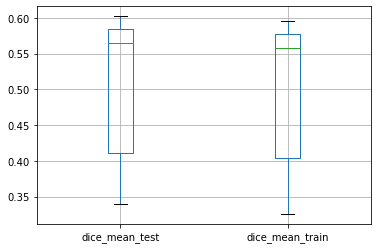

In [118]:
peformance_df[["dice_mean_test","dice_mean_train"]].boxplot()

<AxesSubplot:>

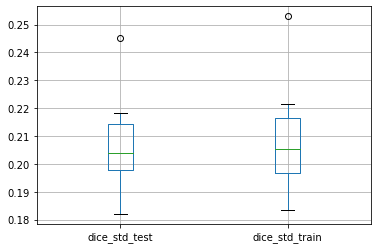

In [119]:
peformance_df[["dice_std_test","dice_std_train"]].boxplot()

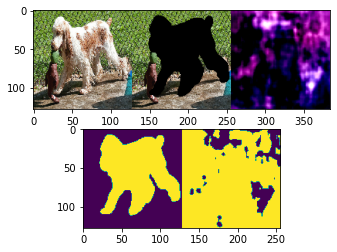

In [129]:
import random
reconstruct = seghead(next(iter(seg_train))[0]).shape
threshold_intensity = 0.01
skip = random.randint(0,70)
image,seg_base = next(iter(zip(img_test.skip(skip),seg_test.skip(skip))))
imgdecom = imghead(image[0])
imgdecom = tf.reshape(imgdecom,(1,-1))
segdecom = tf.linalg.matvec(A,imgdecom,transpose_a=True)+b
seg = seginvhead(tf.reshape(segdecom,(reconstruct)))
y_true = tf.cast(tf.reduce_min(seg_base[0],2)==0,tf.float64)
y_pred = tf.cast(tf.reduce_min(seg[0],2)<threshold_intensity,tf.float64)
plt.subplot(2,1,1)
plt.imshow(np.hstack([image[0],seg_base[0],seg[0]]))
plt.subplot(2,1,2)
plt.imshow(np.hstack([y_true,y_pred]))


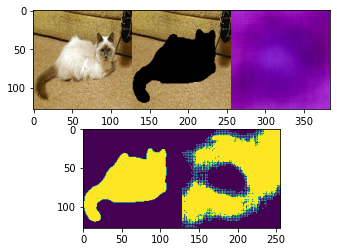

In [105]:
import random
threshold_intensity = 0.001
skip = random.randint(0,70)
image,seg_base = next(iter(zip(img_test.skip(skip),seg_test.skip(skip))))
imgdecom = imghead(image[0])
conv = tf.nn.conv2d(imgdecom, A,1,"VALID")
conv = tf.nn.bias_add(conv,b)
seg = seginvhead(conv)
y_true = tf.cast(tf.reduce_min(seg_base[0],2)==0,tf.float64)
y_pred = tf.cast(tf.reduce_min(seg[0],2)<threshold_intensity,tf.float64)
plt.subplot(2,1,1)
plt.imshow(np.hstack([image[0],seg_base[0],seg[0]]))
plt.subplot(2,1,2)
plt.imshow(np.hstack([y_true,y_pred]))

In [1]:
import pandas as pd

In [71]:
pd.read_csv("conv_formal_experiment")[["dice_mean_test","dice_std_test","dice_mean_train","dice_std_train"]]

,dice_mean_test,dice_std_test,dice_mean_train,dice_std_train
0,0.516062,0.182558,0.539833,0.210776
1,0.355462,0.216621,0.348408,0.226357
2,0.345049,0.214888,0.335443,0.224915
3,0.361819,0.218507,0.354403,0.226326
4,0.349160,0.224643,0.338126,0.227734
